In [1]:
import numpy as np
import random
import geopandas as gpd
import contextily as ctx
import osmnx as ox
import networkx as nx
import matplotlib
import h3
import pandas as pd
import geodatasets
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Polygon, Point
from shapely.strtree import STRtree
from math import pi, cos, sin, exp, sqrt
from geopy.distance import geodesic

/Users/javad/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/javad/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/Users/javad/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Define Base Graphs

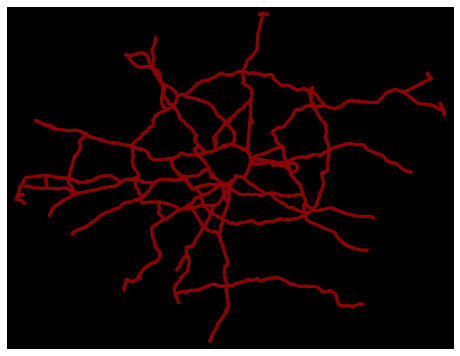

In [2]:
custom_filter = '["highway"~"motorway|trunk"]'
place_name = "London, England"

G_highways_london = ox.graph_from_place(place_name, network_type='drive',
                                        custom_filter=custom_filter)

fig, ax = ox.plot.plot_graph(G_highways_london, node_size=0,
                             node_color='darkred', edge_color='darkred',
                             edge_linewidth=3, bgcolor='black')

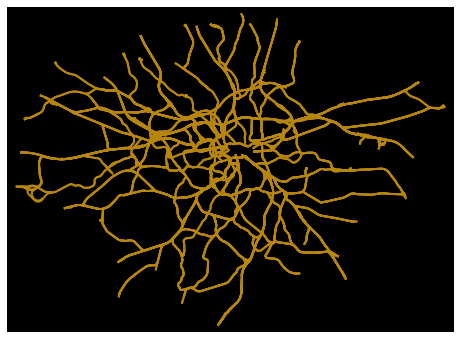

In [3]:
custom_filter = '["railway"~"subway|light_rail|rail"]'
place_name = "London, England"
G_rail_london = ox.graph_from_place(place_name, network_type='drive',
                                    custom_filter=custom_filter)

ox.plot.plot_graph(G_rail_london, node_size=0,
                   node_color='blue', edge_color='darkgoldenrod',
                   edge_linewidth=2, bgcolor='black')

plt.show()

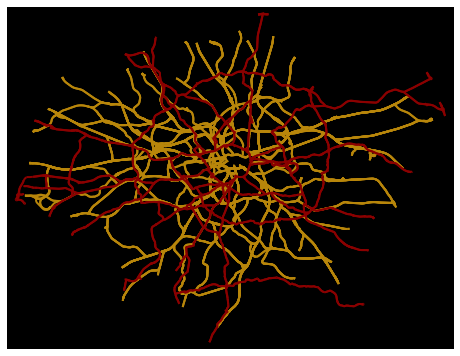

In [4]:
G = nx.compose(G_rail_london, G_highways_london)


ec = ['darkred' if 'highway' in d else 'darkgoldenrod' for _, _, _, d in G.edges(keys=True, data=True)]

fig, ax = ox.plot_graph(G, bgcolor='black', edge_color=ec,
                        node_size=0, edge_linewidth=2,
                        show=False, close=False)

plt.show()

In [5]:
G_proj = ox.project_graph(G, to_crs='epsg:3857')
G_rail_proj = ox.project_graph(G_rail_london, to_crs='epsg:3857')
G_highways_proj = ox.project_graph(G_highways_london, to_crs='epsg:3857')

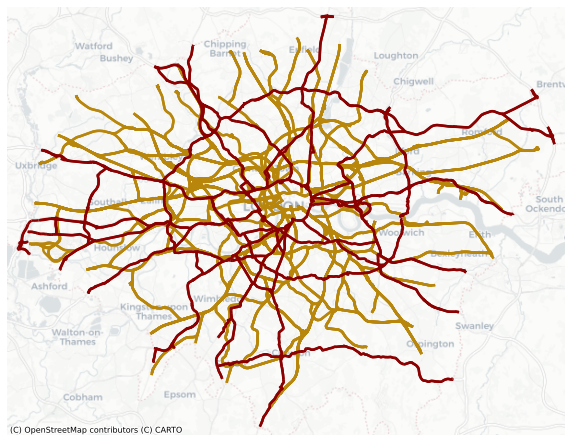

In [6]:
ec = ['darkred' if 'highway' in d else 'darkgoldenrod' for _, _, _, d in G_proj.edges(keys=True, data=True)]

fig, ax = ox.plot_graph(G_proj, bgcolor='white', edge_color=ec,
                        node_size=0, edge_linewidth=2.5,
                        show=False, close=False, figsize=(10,10))

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron,
                alpha=0.8, crs=G_proj.graph['crs'])

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

plt.show()

In [7]:
def graph_to_shape(graph_proj):
    edges = []
    for u, v, k, data in graph_proj.edges(keys=True, data=True):
        if 'geometry' in data:
            geom = data['geometry']
        else:
            # Create a straight LineString if geometry is missing
            point_u = (graph_proj.nodes[u]['x'], graph_proj.nodes[u]['y'])
            point_v = (graph_proj.nodes[v]['x'], graph_proj.nodes[v]['y'])
            geom = LineString([point_u, point_v])

        edges.append({
            'u': u,
            'v': v,
            'key': k,
            'geometry': geom,
            **data  # include other attributes
        })

    # Create GeoDataFrame
    edges_gdf = gpd.GeoDataFrame(edges, crs=graph_proj.graph['crs'])
    
    return edges_gdf

# Define Hex Grid

In [2]:
london = gpd.read_file("london_boroughs.geojson")
london_combined = london.dissolve()
geometry = london_combined.geometry.values[0]
coords = geometry.exterior.coords
latlng_coords = [[y, x] for x, y in coords]

In [3]:
poly = h3.LatLngPoly(latlng_coords)
cells = h3.h3shape_to_cells(poly, res=6)

In [4]:
def plot_df(df, column=None, ax=None):
    "Plot based on the `geometry` column of a GeoPandas dataframe"
    df = df.copy()
    df = df.to_crs(epsg=3857)  # web mercator

    if ax is None:
        _, ax = plt.subplots(figsize=(8,8))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    df.plot(
        ax=ax,
        alpha=0.5, edgecolor='k',
        column=column, categorical=True,
        legend=True, legend_kwds={'loc': 'upper left'},
    )
    ctx.add_basemap(ax, crs=df.crs, source=ctx.providers.CartoDB.Positron)


def plot_shape(shape, ax=None):
    df = gpd.GeoDataFrame({'geometry': [shape]}, crs='EPSG:4326')
    plot_df(df, ax=ax)


def plot_cells(cells, ax=None):
    shape = h3.cells_to_h3shape(cells)
    plot_shape(shape, ax=ax)


def plot_shape_and_cells(shape, res=9):
    fig, axs = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
    plot_shape(shape, ax=axs[0])
    plot_cells(h3.h3shape_to_cells(shape, res), ax=axs[1])
    fig.tight_layout()

<LatLngPoly: [10976]>


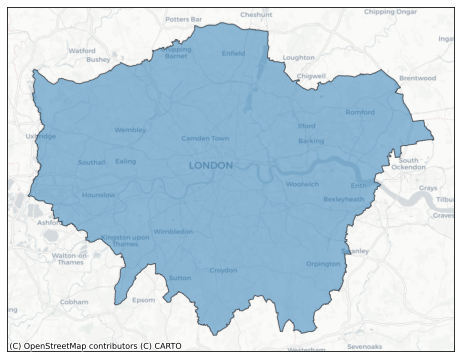

In [5]:
poly = h3.LatLngPoly(latlng_coords)
print(poly)
plot_shape(poly)

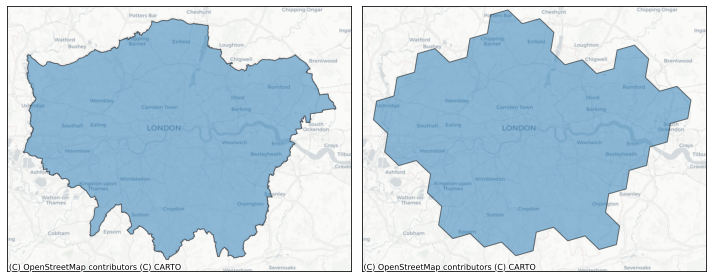

In [6]:
plot_shape_and_cells(poly, 6)

In [10]:
cells = h3.h3shape_to_cells(poly, res=6)

In [11]:
polygons = [Polygon([(lon, lat) for lat, lon in h3.cell_to_boundary(cell)]) for cell in cells]
hex_gdf = gpd.GeoDataFrame({'h3_index': cells, 'geometry': polygons}, crs='EPSG:4326')

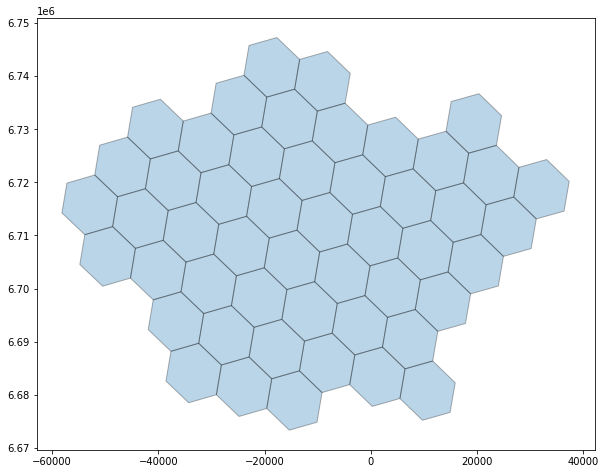

In [12]:
hex_gdf_proj = hex_gdf.to_crs(epsg=3857)

ax = hex_gdf_proj.plot(figsize=(10, 10), alpha=0.3, edgecolor='black')

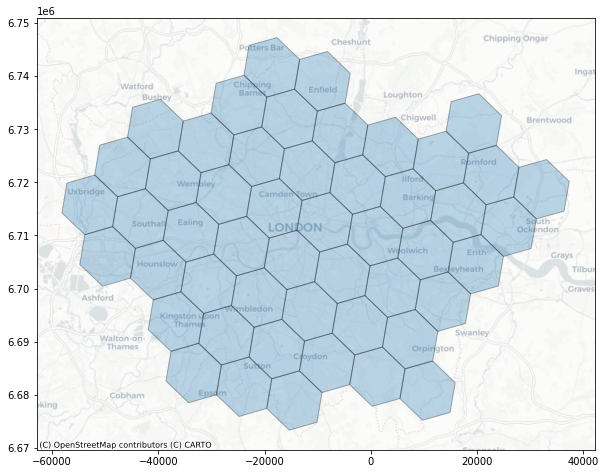

In [17]:
hex_gdf_proj = hex_gdf.to_crs(epsg=3857)

# Plot with background
ax = hex_gdf_proj.plot(figsize=(10, 10), alpha=0.3, edgecolor='black')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron,
                alpha=0.8, crs=hex_gdf_proj.crs)
# plt.show()

# Combining the Grid and the Graph

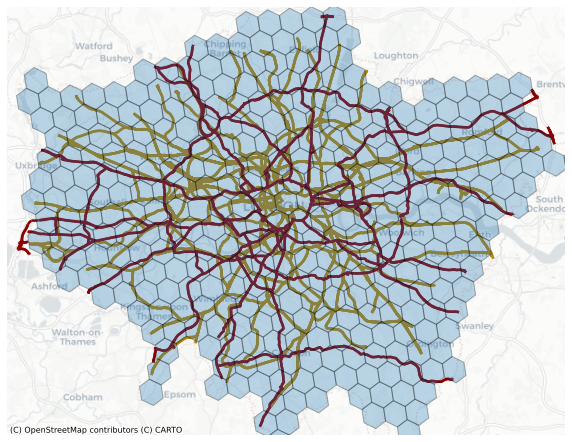

In [17]:
# Compute edge colors for plotting
ec = ['darkred' if 'highway' in d else 'darkgoldenrod' for _, _, _, d in G_proj.edges(keys=True, data=True)]

# Step 1: Plot the graph on a custom axis
fig, ax = ox.plot_graph(G_proj, bgcolor='white', edge_color=ec,
                        node_size=0, edge_linewidth=2.5,
                        show=False, close=False, figsize=(10,10))


# Step 3: Plot the GeoDataFrame on the same axis
hex_gdf_proj.plot(ax=ax, alpha=0.3, edgecolor='black')

# Step 4: Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron,
                alpha=0.8, crs=G_proj.graph['crs'])

# Step 5: Restore original axis limits
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Step 6: Show the figure
plt.show()

In [18]:
def get_hex_sides(hex_gdf_proj):
    hex_sides = []

    for idx, row in hex_gdf_proj.iterrows():
        polygon = row.geometry
        coords = list(polygon.exterior.coords)
        # create LineString for each side of the hexagon
        for i in range(len(coords) - 1):
            line = LineString([coords[i], coords[i+1]])
            hex_sides.append({'h3_index': row.h3_index, 'geometry': line})

    # Convert to GeoDataFrame
    sides_gdf = gpd.GeoDataFrame(hex_sides, crs=hex_gdf_proj.crs)
    
    return sides_gdf

sides_gdf = get_hex_sides(hex_gdf_proj)

In [19]:
def get_intersecting_sides(hex_gdf_proj, graph_proj):
    sides_gdf = get_hex_sides(hex_gdf_proj)
    edges_gdf = graph_to_shape(graph_proj)
    intersecting_sides = gpd.sjoin(sides_gdf, edges_gdf[['geometry']], how='inner', predicate='intersects')
    intersecting_sides = intersecting_sides.drop_duplicates(subset=['geometry'])
    
    return intersecting_sides

intersecting_sides = get_intersecting_sides(hex_gdf_proj, G_highways_proj)

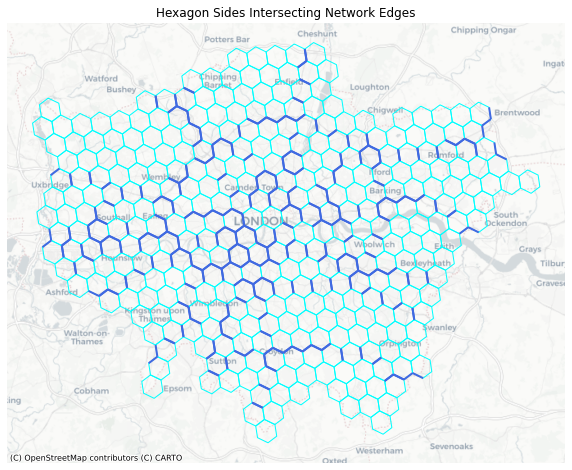

In [20]:
ax = hex_gdf_proj.plot(edgecolor='cyan', facecolor='none', figsize=(10, 10))
intersecting_sides.plot(ax=ax, color='royalblue', linewidth=2)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=sides_gdf.crs)

plt.title("Hexagon Sides Intersecting Network Edges")
plt.axis('off')

plt.show()

In [36]:
hex_centroids = hex_gdf_proj.copy()
hex_centroids['centroid'] = hex_centroids.geometry.centroid
centroid_dict = hex_centroids.set_index('h3_index')['centroid'].to_dict()

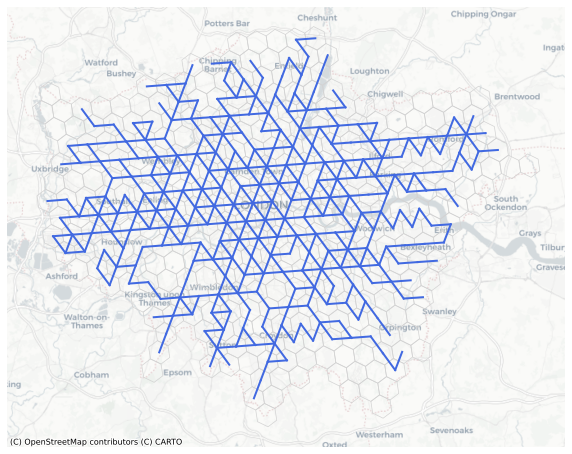

In [37]:
def create_hex_graph(hex_gdf_proj, G_base_proj, color='royalblue'):
    
    intersecting_sides = get_intersecting_sides(hex_gdf_proj, G_base_proj)
    
    
    # Compute centroids
    hex_centroids = hex_gdf_proj.copy()
    hex_centroids['centroid'] = hex_centroids.geometry.centroid
    centroid_dict = hex_centroids.set_index('h3_index')['centroid'].to_dict()

    # Initialize graph
    G_connected = nx.Graph()

    # Spatial index for efficiency
    sindex = hex_gdf_proj.sindex

    for _, row in intersecting_sides.iterrows():
        side_geom = row.geometry

        # Bounding box filter
        candidates = list(sindex.intersection(side_geom.bounds))
        touching_hexes = []

        for idx in candidates:
            hex_row = hex_gdf_proj.iloc[idx]
            if hex_row.geometry.touches(side_geom):
                intersection_geom = hex_row.geometry.intersection(side_geom)
                if intersection_geom.geom_type == 'LineString':
                    touching_hexes.append(hex_row['h3_index'])

        # Add edges only if two hexes share this exact side
        if len(touching_hexes) == 2:
            h1, h2 = touching_hexes
            if h1 in centroid_dict and h2 in centroid_dict:
                G_connected.add_edge(h1, h2)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    hex_gdf_proj.boundary.plot(ax=ax, color='lightgray', linewidth=0.7)

    # Draw edges between centroids
    for u, v in G_connected.edges():
        x = [centroid_dict[u].x, centroid_dict[v].x]
        y = [centroid_dict[u].y, centroid_dict[v].y]
        ax.plot(x, y, color=color, linewidth=2)

    # Basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=hex_gdf_proj.crs)
    plt.axis('off')
    plt.show()

    return G_connected

G_connected = create_hex_graph(hex_gdf_proj, G_proj)

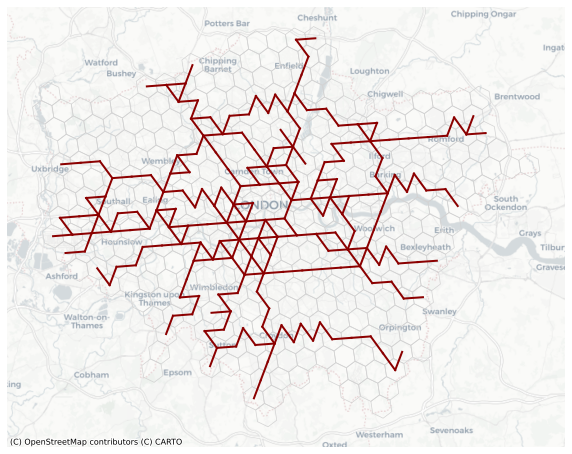

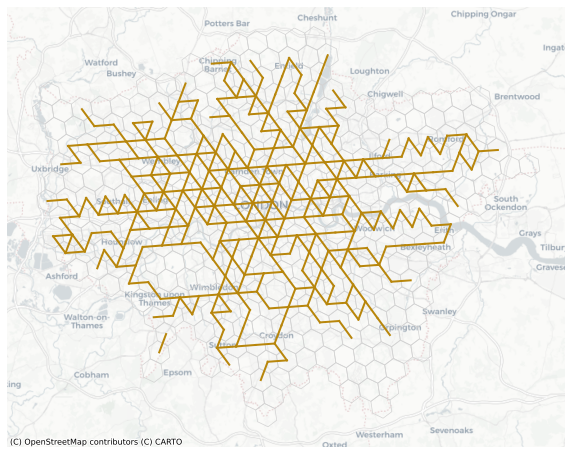

In [38]:
G_connected_highways = create_hex_graph(hex_gdf_proj, G_highways_proj, 'darkred')
G_connected_rail = create_hex_graph(hex_gdf_proj, G_rail_proj, 'darkgoldenrod')

In [39]:
for node in centroid_dict.keys():
    G_connected_highways.add_node(node)
    G_connected_rail.add_node(node)
    G_connected

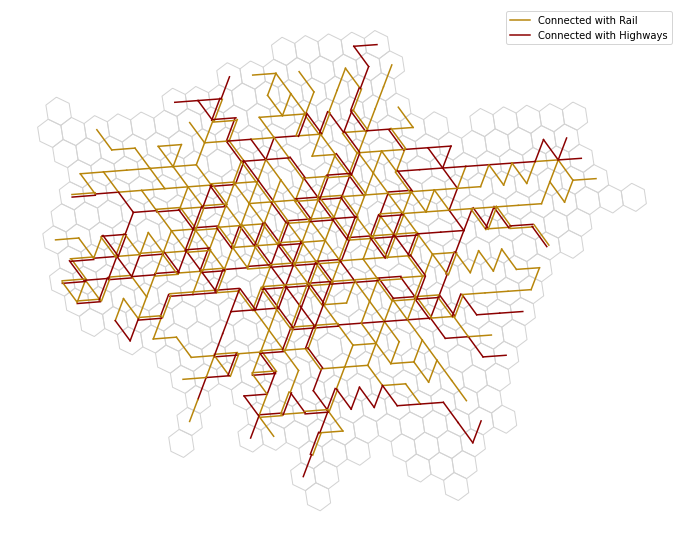

In [40]:
fig, ax = plt.subplots(figsize=(12, 12))

# Plot hexagon outlines
hex_gdf_proj.boundary.plot(ax=ax, color='lightgray', linewidth=1)

# Normalize edges as sorted tuples to ignore direction
def normalize_edges(G):
    return {tuple(sorted(edge)) for edge in G.edges()}

edges_1 = normalize_edges(G_connected_highways)
edges_2 = normalize_edges(G_connected_rail)
all_edges = edges_1.union(edges_2)

# Offset helper: returns coordinates of an edge shifted perpendicular by `offset`
def offset_coords(p1, p2, offset):
    dx, dy = p2.x - p1.x, p2.y - p1.y
    length = np.hypot(dx, dy)
    if length == 0:
        return [(p1.x, p1.y), (p2.x, p2.y)]
    ox, oy = -dy / length * offset, dx / length * offset
    return [(p1.x + ox, p1.y + oy), (p2.x + ox, p2.y + oy)]

for edge in all_edges:
    u, v = edge
    if u not in centroid_dict or v not in centroid_dict:
        continue

    p1, p2 = centroid_dict[u], centroid_dict[v]
    in_1 = edge in edges_1
    in_2 = edge in edges_2

    if in_1 and in_2:
        # Offset both ways to show side-by-side
        coords1 = offset_coords(p1, p2, offset=200)
        coords2 = offset_coords(p1, p2, offset=-200)
        ax.plot(*zip(*coords1), color='darkred', linewidth=1.5, label='Connected with Highways')
        ax.plot(*zip(*coords2), color='darkgoldenrod', linewidth=1.5, label='Connected with Rail')
    elif in_1:
        coords = offset_coords(p1, p2, offset=0)
        ax.plot(*zip(*coords), color='darkred', linewidth=1.5, label='Connected with Highways')
    elif in_2:
        coords = offset_coords(p1, p2, offset=0)
        ax.plot(*zip(*coords), color='darkgoldenrod', linewidth=1.5, label='Connected with Rail')

# Add basemap
# ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=hex_gdf_proj.crs)

# Remove duplicate labels in legend
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys())

plt.axis('off')
plt.show()


In [41]:
def get_adj_matrix(connected_graph):
    nodes = sorted(connected_graph.nodes)

    adj_matrix = pd.DataFrame(0, index=nodes, columns=nodes, dtype=int)
    
    undirected_graph = connected_graph.to_undirected()

    for u, v in undirected_graph.edges:
        adj_matrix.at[u, v] = 1
        adj_matrix.at[v, u] = 1

    return adj_matrix

In [42]:
adj_mat_highways = get_adj_matrix(G_connected_highways)
adj_mat_rail = get_adj_matrix(G_connected_rail)
adj_mat_all = get_adj_matrix(G_connected)

In [43]:
adj_mat_all.sum().sum()

956

# Modelling Commodity Flow

In [44]:
all_nodes = list(centroid_dict.keys())

# Initialize flow_mat with zeros
flow_mat = pd.DataFrame(0, index=all_nodes, columns=all_nodes, dtype=float)

# First layer: direct neighbors (value 3)
for node in G_connected.nodes:
    for neighbor in G_connected.neighbors(node):
        flow_mat.loc[node, neighbor] = 7
        flow_mat.loc[neighbor, node] = 7

# Second layer: neighbors of neighbors (value 2)
for node in G_connected.nodes:
    level_1 = set(G_connected.neighbors(node))
    level_2 = set()
    for n1 in level_1:
        level_2.update(set(G_connected.neighbors(n1)))
    level_2 -= level_1
    level_2.discard(node)
    for n2 in level_2:
        if flow_mat.loc[node, n2] == 0:
            flow_mat.loc[node, n2] = 6
            flow_mat.loc[n2, node] = 6

# Third layer: neighbors of neighbors of neighbors (value 1)
for node in G_connected.nodes:
    level_1 = set(G_connected.neighbors(node))
    level_2 = set()
    for n1 in level_1:
        level_2.update(set(G_connected.neighbors(n1)))
    level_2 -= level_1
    level_2.discard(node)
    
    level_3 = set()
    for n2 in level_2:
        level_3.update(set(G_connected.neighbors(n2)))
    level_3 -= level_2
    level_3 -= level_1
    level_3.discard(node)

    for n3 in level_3:
        if flow_mat.loc[node, n3] == 0:
            flow_mat.loc[node, n3] = 4
            flow_mat.loc[n3, node] = 4

In [45]:
flow_mat

87195dac5ffffff  87194e6c3ffffff  87194ac06ffffff  \
87195dac5ffffff              0.0              0.0              0.0   
87194e6c3ffffff              0.0              0.0              0.0   
87194ac06ffffff              0.0              0.0              0.0   
87194ad33ffffff              0.0              0.0              0.0   
87195d364ffffff              0.0              0.0              0.0   
...                          ...              ...              ...   
87194ad9cffffff              0.0              0.0              0.0   
87194e60effffff              0.0              0.0              0.0   
87194e69dffffff              0.0              0.0              0.0   
87194ad8dffffff              0.0              0.0              0.0   
87194e68effffff              0.0              0.0              0.0   

                 87194ad33ffffff  87195d364ffffff  87194ad24ffffff  \
87195dac5ffffff              0.0              0.0              0.0   
87194e6c3ffffff              0.0              0.0              0.0   
87194ac06ffffff              0.0              0.0              0.0   
87194ad33ffffff              0.0              0.0              0.0   
87195d364ffffff              0.0              0.0              0.0   
...                          ...              ...              ...   
87194ad9cffffff              0.0              0.0              0.0   
87194e60effffff              0.0              0.0              0.0   
87194e69dffffff              0.0              0.0              6.0   
87194ad8dffffff              0.0              0.0              0.0   
87194e68effffff              0.0              0.0              4.0   

                 87194adb3ffffff  87194ad15ffffff  87194ada4ffffff  \
87195dac5ffffff              0.0              0.0              0.0   
87194e6c3ffffff              0.0              0.0              0.0   
87194ac06ffffff              0.0              0.0              0.0   
87194ad33ffffff              0.0              7.0              0.0   
87195d364ffffff              0.0              0.0              0.0   
...                          ...              ...              ...   
87194ad9cffffff              0.0              0.0              0.0   
87194e60effffff              0.0              0.0              0.0   
87194e69dffffff              0.0              0.0              0.0   
87194ad8dffffff              0.0              0.0              0.0   
87194e68effffff              0.0              0.0              0.0   

                 87194ad06ffffff  ...  87194ad1cffffff  87194adabffffff  \
87195dac5ffffff              0.0  ...              0.0              0.0   
87194e6c3ffffff              0.0  ...              0.0              0.0   
87194ac06ffffff              0.0  ...              0.0              0.0   
87194ad33ffffff              7.0  ...              4.0              0.0   
87195d364ffffff              0.0  ...              0.0              0.0   
...                          ...  ...              ...              ...   
87194ad9cffffff              0.0  ...              0.0              0.0   
87194e60effffff              0.0  ...              0.0              0.0   
87194e69dffffff              0.0  ...              0.0              0.0   
87194ad8dffffff              0.0  ...              0.0              7.0   
87194e68effffff              0.0  ...              0.0              0.0   

                 87194e61dffffff  87194e6acffffff  87194ad0dffffff  \
87195dac5ffffff              0.0              0.0              0.0   
87194e6c3ffffff              0.0              0.0              0.0   
87194ac06ffffff              0.0              0.0              0.0   
87194ad33ffffff              0.0              0.0              0.0   
87195d364ffffff              0.0              0.0              0.0   
...                          ...              ...              ...   
87194ad9cffffff              0.0              0.0              0.0   
87194e60effffff              7.0 

In [47]:
np.random.seed(0)

indices = [(i, j) for i in range(len(flow_mat)) for j in range(i+1, len(flow_mat))]

# Randomly select 20 unique pairs
selected_indices = np.random.choice(len(indices), size=20, replace=False)

for idx in selected_indices:
    i, j = indices[idx]
    if i == j:
        continue
    flow_mat.iat[i, j] += 5
    flow_mat.iat[j, i] += 5  # ensure symmetry

# Optimisation

In [111]:
def euclidean_distance(coord1, coord2):
    return sqrt((coord1.x - coord2.x)**2 + (coord1.y - coord2.y)**2) / 1000.0

from itertools import combinations

def precompute_distances(centroid_dict):
    dist_dict = {}
    for u, coord_u in centroid_dict.items():
        dist_dict[u] = {}
        for v, coord_v in centroid_dict.items():
            dist = sqrt((coord_u.x - coord_v.x)**2 + (coord_u.y - coord_v.y)**2) / 1000.0
            dist_dict[u][v] = dist
    return dist_dict

def compute_total_benefit_np(G, benefit_array, node_index, centroid_dict, dist_dict, alpha=3.0, distance_cap=5.0):
    total_benefit = 0
    connected_nodes = set()
    components = list(nx.connected_components(G))

    # Step 1: Sum benefits for all connected node pairs
    for component in components:
        nodes = list(component)
        connected_nodes.update(nodes)
        indices = [node_index[n] for n in nodes]
        submatrix = benefit_array[np.ix_(indices, indices)]
        total_benefit += np.sum(np.triu(submatrix, k=1))  # avoid double counting

    # Step 2: Redistribute from disconnected nodes
    all_nodes = set(node_index.keys())
    disconnected_nodes = all_nodes - connected_nodes

    for u in disconnected_nodes:
        u_idx = node_index[u]

        # Find the closest connected node
        closest_node = None
        min_dist = float("inf")
        for v in connected_nodes:
            dist = dist_dict[u][v]
            if dist < min_dist:
                min_dist = dist
                closest_node = v

        if min_dist <= distance_cap:
            v_idx = node_index[closest_node]
            for w in connected_nodes:
                if w == u:
                    continue
                w_idx = node_index[w]
                benefit = benefit_array[u_idx, w_idx]
                total_benefit += benefit * np.exp(-alpha * min_dist)

    return total_benefit

In [112]:
TARGET_EDGE_NUM = 50
MUTATION_RATE = 0.17 

# def compute_total_benefit(G, benefits):
#     total = 0
#     for component in nx.connected_components(G):
#         nodes = list(component)
#         for i in range(len(nodes)):
#             for j in range(i+1, len(nodes)):
#                 u, v = nodes[i], nodes[j]
#                 total += benefits.loc[u, v]
#     return total

def create_graph_from_edges(edge_list, nodes):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edge_list)
    return G

def generate_initial_population(edges, population_size, k):
    return [random.sample(edges, k) for _ in range(population_size)]

# def crossover(parent1, parent2, k):
#     combined = list(set(parent1) | set(parent2))
#     if len(combined) > k:
#         return random.sample(combined, k)
#     else:
#         # pad with random edges to ensure size k
#         return combined + random.sample(list(set(edges) - set(combined)), k - len(combined))

def crossover(parent1, parent2, k):
    child = []
    candidates = list(set(parent1 + parent2))
    while len(child) < k:
        e = random.choice(candidates)
        if e not in child:
            child.append(e)
    return child

def mutate(chromosome, edges, mutation_rate=MUTATION_RATE):
    chromosome = chromosome.copy()
    for i in range(len(chromosome)):
        if random.random() < mutation_rate:
            new_edge = random.choice(list(set(edges) - set(chromosome)))
            chromosome[i] = new_edge
    return chromosome

def select_parents(population, fitnesses):
    total_fitness = sum(fitnesses)
    probs = [f / total_fitness for f in fitnesses]
    parents = random.choices(population, weights=probs, k=2)
    return parents

def tournament_selection(population, fitnesses, tournament_size=5):
    selected = random.sample(list(zip(population, fitnesses)), tournament_size)
    return max(selected, key=lambda x: x[1])[0]

def genetic_algorithm(edges, benefits, node_list, generations, population_size, k, dist_dict):
    population = generate_initial_population(edges, population_size, k)
    best_fitness_history = []
    
#     # Convert benefits to numpy sssuming `benefits` is a DataFrame with symmetric values and node labels as both index and columns
#     benefit_array = benefits.to_numpy()
#     node_list = benefits.index.to_list()
    node_index = {node: i for i, node in enumerate(node_list)}  # map from node to row/col index
    benefit_array = benefits


    for generation in range(generations):
        fitnesses = []
        for chromo in population:
            G = create_graph_from_edges(chromo, node_list)
            # fitnesses.append(compute_total_benefit(G, benefits))
            fitnesses.append(compute_total_benefit_np(G, benefits, node_index, centroid_dict, dist_dict))
            

        ### Option 1
        elite_count = 5  # or any small number like 2–10
            # Zip population with their fitnesses and sort in descending order
        sorted_pop = sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True)
            # Keep top N elites
        new_population = [ind for ind, _ in sorted_pop[:elite_count]]
        best_fitness = sorted_pop[0][1]
        ###
        ### Option 2
        # best_idx = np.argmax(fitnesses)
        # best_fitness = fitnesses[best_idx]
        # new_population = [population[best_idx]]  # elitism
        ###
        best_fitness_history.append(best_fitness)
        print(f"Generation {generation}: Best Benefit = {best_fitness}")

        

        while len(new_population) < population_size:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            child = crossover(parent1, parent2, k)
            child = mutate(child, edges, mutation_rate=MUTATION_RATE)
            new_population.append(child)

        population = new_population

    # Final best
    # final_fitnesses = [compute_total_benefit(create_graph_from_edges(chromo, nodes), benefits)
    #                    for chromo in population]
    final_fitnesses = [compute_total_benefit_np(create_graph_from_edges(chromo, node_list), benefits, node_index, centroid_dict, dist_dict)
                       for chromo in population]
    
    best_idx = np.argmax(final_fitnesses)
    best_edges = population[best_idx]

    return best_edges, best_fitness_history


/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_1826/4049911473.py:21: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  return [random.sample(edges, k) for _ in range(population_size)]


Generation 0: Best Benefit = 623.0
Generation 1: Best Benefit = 644.0
Generation 2: Best Benefit = 660.0
Generation 3: Best Benefit = 846.0
Generation 4: Best Benefit = 846.0
Generation 5: Best Benefit = 858.0
Generation 6: Best Benefit = 858.0
Generation 7: Best Benefit = 957.0
Generation 8: Best Benefit = 957.0
Generation 9: Best Benefit = 957.0
Generation 10: Best Benefit = 957.0
Generation 11: Best Benefit = 957.0
Generation 12: Best Benefit = 957.0
Generation 13: Best Benefit = 957.0
Generation 14: Best Benefit = 1011.0
Generation 15: Best Benefit = 1172.0
Generation 16: Best Benefit = 1172.0
Generation 17: Best Benefit = 1172.0
Generation 18: Best Benefit = 1172.0
Generation 19: Best Benefit = 1172.0
Generation 20: Best Benefit = 1172.0
Generation 21: Best Benefit = 1172.0
Generation 22: Best Benefit = 1172.0
Generation 23: Best Benefit = 1172.0
Generation 24: Best Benefit = 1172.0
Generation 25: Best Benefit = 1172.0
Generation 26: Best Benefit = 1172.0
Generation 27: Best Benef

Generation 219: Best Benefit = 1393.0
Generation 220: Best Benefit = 1393.0
Generation 221: Best Benefit = 1447.0
Generation 222: Best Benefit = 1447.0
Generation 223: Best Benefit = 1447.0
Generation 224: Best Benefit = 1447.0
Generation 225: Best Benefit = 1447.0
Generation 226: Best Benefit = 1447.0
Generation 227: Best Benefit = 1447.0
Generation 228: Best Benefit = 1447.0
Generation 229: Best Benefit = 1447.0
Generation 230: Best Benefit = 1447.0
Generation 231: Best Benefit = 1447.0
Generation 232: Best Benefit = 1447.0
Generation 233: Best Benefit = 1447.0
Generation 234: Best Benefit = 1447.0
Generation 235: Best Benefit = 1447.0
Generation 236: Best Benefit = 1447.0
Generation 237: Best Benefit = 1447.0
Generation 238: Best Benefit = 1447.0
Generation 239: Best Benefit = 1447.0
Generation 240: Best Benefit = 1447.0
Generation 241: Best Benefit = 1447.0
Generation 242: Best Benefit = 1447.0
Generation 243: Best Benefit = 1447.0
Generation 244: Best Benefit = 1447.0
Generation 2

Generation 435: Best Benefit = 1564.0
Generation 436: Best Benefit = 1564.0
Generation 437: Best Benefit = 1564.0
Generation 438: Best Benefit = 1564.0
Generation 439: Best Benefit = 1564.0
Generation 440: Best Benefit = 1564.0
Generation 441: Best Benefit = 1564.0
Generation 442: Best Benefit = 1564.0
Generation 443: Best Benefit = 1564.0
Generation 444: Best Benefit = 1564.0
Generation 445: Best Benefit = 1564.0
Generation 446: Best Benefit = 1564.0
Generation 447: Best Benefit = 1564.0
Generation 448: Best Benefit = 1564.0
Generation 449: Best Benefit = 1564.0
Generation 450: Best Benefit = 1564.0
Generation 451: Best Benefit = 1564.0
Generation 452: Best Benefit = 1564.0
Generation 453: Best Benefit = 1564.0
Generation 454: Best Benefit = 1564.0
Generation 455: Best Benefit = 1564.0
Generation 456: Best Benefit = 1564.0
Generation 457: Best Benefit = 1564.0
Generation 458: Best Benefit = 1564.0
Generation 459: Best Benefit = 1564.0
Generation 460: Best Benefit = 1564.0
Generation 4

Generation 651: Best Benefit = 1673.0
Generation 652: Best Benefit = 1673.0
Generation 653: Best Benefit = 1673.0
Generation 654: Best Benefit = 1673.0
Generation 655: Best Benefit = 1673.0
Generation 656: Best Benefit = 1673.0
Generation 657: Best Benefit = 1673.0
Generation 658: Best Benefit = 1673.0
Generation 659: Best Benefit = 1673.0
Generation 660: Best Benefit = 1673.0
Generation 661: Best Benefit = 1673.0
Generation 662: Best Benefit = 1673.0
Generation 663: Best Benefit = 1673.0
Generation 664: Best Benefit = 1673.0
Generation 665: Best Benefit = 1673.0
Generation 666: Best Benefit = 1673.0
Generation 667: Best Benefit = 1673.0
Generation 668: Best Benefit = 1673.0
Generation 669: Best Benefit = 1673.0
Generation 670: Best Benefit = 1673.0
Generation 671: Best Benefit = 1673.0
Generation 672: Best Benefit = 1673.0
Generation 673: Best Benefit = 1673.0
Generation 674: Best Benefit = 1673.0
Generation 675: Best Benefit = 1673.0
Generation 676: Best Benefit = 1673.0
Generation 6

Generation 867: Best Benefit = 1673.0
Generation 868: Best Benefit = 1673.0
Generation 869: Best Benefit = 1673.0
Generation 870: Best Benefit = 1673.0
Generation 871: Best Benefit = 1673.0
Generation 872: Best Benefit = 1673.0
Generation 873: Best Benefit = 1673.0
Generation 874: Best Benefit = 1673.0
Generation 875: Best Benefit = 1673.0
Generation 876: Best Benefit = 1673.0
Generation 877: Best Benefit = 1673.0
Generation 878: Best Benefit = 1673.0
Generation 879: Best Benefit = 1673.0
Generation 880: Best Benefit = 1673.0
Generation 881: Best Benefit = 1673.0
Generation 882: Best Benefit = 1673.0
Generation 883: Best Benefit = 1673.0
Generation 884: Best Benefit = 1673.0
Generation 885: Best Benefit = 1673.0
Generation 886: Best Benefit = 1673.0
Generation 887: Best Benefit = 1673.0
Generation 888: Best Benefit = 1673.0
Generation 889: Best Benefit = 1673.0
Generation 890: Best Benefit = 1673.0
Generation 891: Best Benefit = 1673.0
Generation 892: Best Benefit = 1673.0
Generation 8

Generation 1081: Best Benefit = 1673.0
Generation 1082: Best Benefit = 1673.0
Generation 1083: Best Benefit = 1673.0
Generation 1084: Best Benefit = 1673.0
Generation 1085: Best Benefit = 1673.0
Generation 1086: Best Benefit = 1673.0
Generation 1087: Best Benefit = 1673.0
Generation 1088: Best Benefit = 1673.0
Generation 1089: Best Benefit = 1673.0
Generation 1090: Best Benefit = 1673.0
Generation 1091: Best Benefit = 1673.0
Generation 1092: Best Benefit = 1673.0
Generation 1093: Best Benefit = 1673.0
Generation 1094: Best Benefit = 1673.0
Generation 1095: Best Benefit = 1673.0
Generation 1096: Best Benefit = 1673.0
Generation 1097: Best Benefit = 1673.0
Generation 1098: Best Benefit = 1673.0
Generation 1099: Best Benefit = 1673.0
Generation 1100: Best Benefit = 1673.0
Generation 1101: Best Benefit = 1673.0
Generation 1102: Best Benefit = 1673.0
Generation 1103: Best Benefit = 1673.0
Generation 1104: Best Benefit = 1673.0
Generation 1105: Best Benefit = 1673.0
Generation 1106: Best Ben

Generation 1292: Best Benefit = 1674.0
Generation 1293: Best Benefit = 1674.0
Generation 1294: Best Benefit = 1674.0
Generation 1295: Best Benefit = 1674.0
Generation 1296: Best Benefit = 1674.0
Generation 1297: Best Benefit = 1674.0
Generation 1298: Best Benefit = 1674.0
Generation 1299: Best Benefit = 1674.0
Generation 1300: Best Benefit = 1674.0
Generation 1301: Best Benefit = 1674.0
Generation 1302: Best Benefit = 1674.0
Generation 1303: Best Benefit = 1674.0
Generation 1304: Best Benefit = 1674.0
Generation 1305: Best Benefit = 1674.0
Generation 1306: Best Benefit = 1674.0
Generation 1307: Best Benefit = 1674.0
Generation 1308: Best Benefit = 1674.0
Generation 1309: Best Benefit = 1674.0
Generation 1310: Best Benefit = 1674.0
Generation 1311: Best Benefit = 1674.0
Generation 1312: Best Benefit = 1674.0
Generation 1313: Best Benefit = 1674.0
Generation 1314: Best Benefit = 1674.0
Generation 1315: Best Benefit = 1674.0
Generation 1316: Best Benefit = 1674.0
Generation 1317: Best Ben

Generation 1503: Best Benefit = 1674.0
Generation 1504: Best Benefit = 1674.0
Generation 1505: Best Benefit = 1674.0
Generation 1506: Best Benefit = 1674.0
Generation 1507: Best Benefit = 1674.0
Generation 1508: Best Benefit = 1674.0
Generation 1509: Best Benefit = 1674.0
Generation 1510: Best Benefit = 1674.0
Generation 1511: Best Benefit = 1674.0
Generation 1512: Best Benefit = 1674.0
Generation 1513: Best Benefit = 1674.0
Generation 1514: Best Benefit = 1674.0
Generation 1515: Best Benefit = 1674.0
Generation 1516: Best Benefit = 1674.0
Generation 1517: Best Benefit = 1674.0
Generation 1518: Best Benefit = 1674.0
Generation 1519: Best Benefit = 1674.0
Generation 1520: Best Benefit = 1674.0
Generation 1521: Best Benefit = 1674.0
Generation 1522: Best Benefit = 1674.0
Generation 1523: Best Benefit = 1674.0
Generation 1524: Best Benefit = 1674.0
Generation 1525: Best Benefit = 1674.0
Generation 1526: Best Benefit = 1674.0
Generation 1527: Best Benefit = 1674.0
Generation 1528: Best Ben

Generation 1714: Best Benefit = 1726.0
Generation 1715: Best Benefit = 1726.0
Generation 1716: Best Benefit = 1726.0
Generation 1717: Best Benefit = 1726.0
Generation 1718: Best Benefit = 1726.0
Generation 1719: Best Benefit = 1726.0
Generation 1720: Best Benefit = 1726.0
Generation 1721: Best Benefit = 1726.0
Generation 1722: Best Benefit = 1726.0
Generation 1723: Best Benefit = 1726.0
Generation 1724: Best Benefit = 1726.0
Generation 1725: Best Benefit = 1726.0
Generation 1726: Best Benefit = 1726.0
Generation 1727: Best Benefit = 1726.0
Generation 1728: Best Benefit = 1726.0
Generation 1729: Best Benefit = 1726.0
Generation 1730: Best Benefit = 1726.0
Generation 1731: Best Benefit = 1726.0
Generation 1732: Best Benefit = 1726.0
Generation 1733: Best Benefit = 1726.0
Generation 1734: Best Benefit = 1726.0
Generation 1735: Best Benefit = 1726.0
Generation 1736: Best Benefit = 1726.0
Generation 1737: Best Benefit = 1726.0
Generation 1738: Best Benefit = 1726.0
Generation 1739: Best Ben

Generation 1925: Best Benefit = 1859.0
Generation 1926: Best Benefit = 1859.0
Generation 1927: Best Benefit = 1859.0
Generation 1928: Best Benefit = 1859.0
Generation 1929: Best Benefit = 1859.0
Generation 1930: Best Benefit = 1859.0
Generation 1931: Best Benefit = 1859.0
Generation 1932: Best Benefit = 1859.0
Generation 1933: Best Benefit = 1859.0
Generation 1934: Best Benefit = 1859.0
Generation 1935: Best Benefit = 1859.0
Generation 1936: Best Benefit = 1859.0
Generation 1937: Best Benefit = 1859.0
Generation 1938: Best Benefit = 1859.0
Generation 1939: Best Benefit = 1859.0
Generation 1940: Best Benefit = 1859.0
Generation 1941: Best Benefit = 1859.0
Generation 1942: Best Benefit = 1859.0
Generation 1943: Best Benefit = 1859.0
Generation 1944: Best Benefit = 1859.0
Generation 1945: Best Benefit = 1859.0
Generation 1946: Best Benefit = 1859.0
Generation 1947: Best Benefit = 1859.0
Generation 1948: Best Benefit = 1859.0
Generation 1949: Best Benefit = 1859.0
Generation 1950: Best Ben

Generation 2136: Best Benefit = 1859.0
Generation 2137: Best Benefit = 1859.0
Generation 2138: Best Benefit = 1859.0
Generation 2139: Best Benefit = 1859.0
Generation 2140: Best Benefit = 1859.0
Generation 2141: Best Benefit = 1859.0
Generation 2142: Best Benefit = 1859.0
Generation 2143: Best Benefit = 1859.0
Generation 2144: Best Benefit = 1859.0
Generation 2145: Best Benefit = 1859.0
Generation 2146: Best Benefit = 1859.0
Generation 2147: Best Benefit = 1859.0
Generation 2148: Best Benefit = 1859.0
Generation 2149: Best Benefit = 1859.0
Generation 2150: Best Benefit = 1859.0
Generation 2151: Best Benefit = 1859.0
Generation 2152: Best Benefit = 1859.0
Generation 2153: Best Benefit = 1859.0
Generation 2154: Best Benefit = 1859.0
Generation 2155: Best Benefit = 1859.0
Generation 2156: Best Benefit = 1859.0
Generation 2157: Best Benefit = 1859.0
Generation 2158: Best Benefit = 1859.0
Generation 2159: Best Benefit = 1859.0
Generation 2160: Best Benefit = 1859.0
Generation 2161: Best Ben

Generation 2347: Best Benefit = 1859.0
Generation 2348: Best Benefit = 1859.0
Generation 2349: Best Benefit = 1859.0
Generation 2350: Best Benefit = 1859.0
Generation 2351: Best Benefit = 1859.0
Generation 2352: Best Benefit = 1859.0
Generation 2353: Best Benefit = 1859.0
Generation 2354: Best Benefit = 1859.0
Generation 2355: Best Benefit = 1859.0
Generation 2356: Best Benefit = 1859.0
Generation 2357: Best Benefit = 1859.0
Generation 2358: Best Benefit = 1859.0
Generation 2359: Best Benefit = 1859.0
Generation 2360: Best Benefit = 1859.0
Generation 2361: Best Benefit = 1859.0
Generation 2362: Best Benefit = 1859.0
Generation 2363: Best Benefit = 1859.0
Generation 2364: Best Benefit = 1859.0
Generation 2365: Best Benefit = 1859.0
Generation 2366: Best Benefit = 1859.0
Generation 2367: Best Benefit = 1859.0
Generation 2368: Best Benefit = 1859.0
Generation 2369: Best Benefit = 1859.0
Generation 2370: Best Benefit = 1859.0
Generation 2371: Best Benefit = 1859.0
Generation 2372: Best Ben

Generation 2558: Best Benefit = 1879.0
Generation 2559: Best Benefit = 1879.0
Generation 2560: Best Benefit = 1879.0
Generation 2561: Best Benefit = 1879.0
Generation 2562: Best Benefit = 1879.0
Generation 2563: Best Benefit = 1879.0
Generation 2564: Best Benefit = 1879.0
Generation 2565: Best Benefit = 1879.0
Generation 2566: Best Benefit = 1879.0
Generation 2567: Best Benefit = 1879.0
Generation 2568: Best Benefit = 1879.0
Generation 2569: Best Benefit = 1879.0
Generation 2570: Best Benefit = 1879.0
Generation 2571: Best Benefit = 1879.0
Generation 2572: Best Benefit = 1879.0
Generation 2573: Best Benefit = 1879.0
Generation 2574: Best Benefit = 1879.0
Generation 2575: Best Benefit = 1879.0
Generation 2576: Best Benefit = 1879.0
Generation 2577: Best Benefit = 1879.0
Generation 2578: Best Benefit = 1879.0
Generation 2579: Best Benefit = 1879.0
Generation 2580: Best Benefit = 1879.0
Generation 2581: Best Benefit = 1879.0
Generation 2582: Best Benefit = 1879.0
Generation 2583: Best Ben

Generation 2769: Best Benefit = 1902.0
Generation 2770: Best Benefit = 1902.0
Generation 2771: Best Benefit = 1902.0
Generation 2772: Best Benefit = 1902.0
Generation 2773: Best Benefit = 1902.0
Generation 2774: Best Benefit = 1902.0
Generation 2775: Best Benefit = 1902.0
Generation 2776: Best Benefit = 1902.0
Generation 2777: Best Benefit = 1902.0
Generation 2778: Best Benefit = 1902.0
Generation 2779: Best Benefit = 1902.0
Generation 2780: Best Benefit = 1902.0
Generation 2781: Best Benefit = 1902.0
Generation 2782: Best Benefit = 1902.0
Generation 2783: Best Benefit = 1902.0
Generation 2784: Best Benefit = 1902.0
Generation 2785: Best Benefit = 1902.0
Generation 2786: Best Benefit = 1902.0
Generation 2787: Best Benefit = 1902.0
Generation 2788: Best Benefit = 1902.0
Generation 2789: Best Benefit = 1902.0
Generation 2790: Best Benefit = 1902.0
Generation 2791: Best Benefit = 1902.0
Generation 2792: Best Benefit = 1902.0
Generation 2793: Best Benefit = 1902.0
Generation 2794: Best Ben

Generation 2980: Best Benefit = 1902.0
Generation 2981: Best Benefit = 1902.0
Generation 2982: Best Benefit = 1902.0
Generation 2983: Best Benefit = 1902.0
Generation 2984: Best Benefit = 1902.0
Generation 2985: Best Benefit = 1902.0
Generation 2986: Best Benefit = 1902.0
Generation 2987: Best Benefit = 1902.0
Generation 2988: Best Benefit = 1902.0
Generation 2989: Best Benefit = 1902.0
Generation 2990: Best Benefit = 1902.0
Generation 2991: Best Benefit = 1902.0
Generation 2992: Best Benefit = 1902.0
Generation 2993: Best Benefit = 1902.0
Generation 2994: Best Benefit = 1902.0
Generation 2995: Best Benefit = 1902.0
Generation 2996: Best Benefit = 1902.0
Generation 2997: Best Benefit = 1902.0
Generation 2998: Best Benefit = 1902.0
Generation 2999: Best Benefit = 1902.0


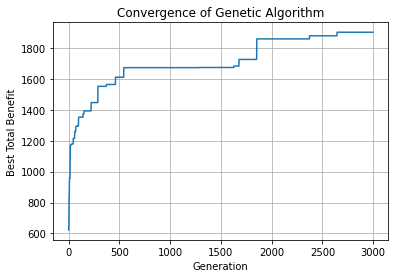

In [113]:
dist_dict = precompute_distances(centroid_dict)
benefit_array = flow_mat.values

best_edges, history = genetic_algorithm(G_connected.edges(),
                                        benefit_array,
                                        list(flow_mat.index),
                                        generations=2000,
                                        population_size=100,
                                        k=TARGET_EDGE_NUM,
                                        dist_dict=dist_dict)

plt.plot(history)
plt.title("Convergence of Genetic Algorithm")
plt.xlabel("Generation")
plt.ylabel("Best Total Benefit")
plt.grid(True)
plt.show()

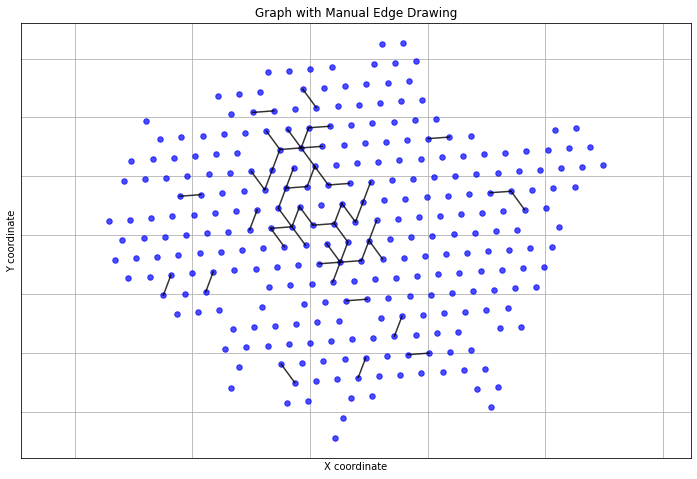

In [114]:
pos = {}
for node in centroid_dict:
    pt = centroid_dict[node]
    pos[node] = (pt.x, pt.y)

def plot_graph_with_manual_edges(G, pos, node_color='blue', edge_color='black'):
    plt.figure(figsize=(12, 8))
    # Draw nodes
    
    nx.draw_networkx_nodes(G, pos, node_size=30, node_color=node_color, alpha=0.7)

    # Draw edges manually
    for u, v in G.edges():
        x_vals = [pos[u][0], pos[v][0]]
        y_vals = [pos[u][1], pos[v][1]]
        plt.plot(x_vals, y_vals, color=edge_color, alpha=0.8, linewidth=1.5)

    plt.title("Graph with Manual Edge Drawing")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.show()

# Call it
G_final = create_graph_from_edges(best_edges, G_final.nodes())
plot_graph_with_manual_edges(G_final, pos)


In [99]:
centroid_dict[node].y

6720096.739299176